In [1]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots","JLD2","FileIO","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using FileIO; 
using ImageMagick; 
using MAT; 
using Statistics: mean
using Plots;
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, Param,progress, sgd,dropout, relu,
Data,sigm, xavier,gpu,softmax
import Knet:param,param0
using Images;
using JLD2,Random

In [2]:
include("minibatch_updated.jl")

In [3]:
atype()=(gpu() >= 0 ? KnetArray{Float32} : Array{Float32})
param(d...; init=xavier, atype=atype())=Param(atype(init(d...)))
param0(d...; atype=atype())=param(d...; init=zeros, atype=atype)

param0 (generic function with 1 method)

In [4]:
function image_data(img,image_size)
    global _imgcache
    if !@isdefined(_imgcache); _imgcache = Dict(); end
        a0=img
        a0=Gray.(a0)
        new_size = ntuple(i->div(size(a0,i)*image_size,minimum(size(a0))),2)
        a1 = Images.imresize(a0, new_size)
        i1 = div(size(a1,1)-image_size,2)
        j1 = div(size(a1,2)-image_size,2)
        b1 = a1[i1+1:i1+image_size,j1+1:j1+image_size]
        b1 = convert(Array{FixedPointNumbers.Normed{UInt8,8},2}, b1)
       # d1 = convert(atype(), b1)
        e1 = reshape(b1[:,:,1], (image_size,image_size,1,1))
        f1 = (255 * e1)
        #g1 = permutedims(f1, [2,1,3,4])
    return f1
end

image_data (generic function with 1 method)

In [5]:
function read_data(data_path,image_size)
i=1
first_r=true
y=[]
x=0
folders=readdir(data_path)
for class in folders
    println("Class number ",i," ",class)
    directory=string(data_path,"/",class)
    for img in readdir(directory)
            
        arr_img=load(string(directory,"/",img))
            
        arr_img=image_data(arr_img,image_size)   
        #=arr_img=Gray.(arr_img)
        arr_img=convert(Array{Float32},arr_img)
        arr_img=reshape(arr_img,(72,72,1,1))=#
        #arr_img=convert(atype(),arr_img)
        label=zeros(size(folders))
        label[i]=1
        if first_r==false
            x=cat(x,arr_img,dims=4)
        else
            #global x=cat(arr_img,dims=4)
            x=cat(arr_img,dims=4)
        end
        push!(y,i)
        first_r=false
    end
    i+=1
    end
println(size(y))
println(size(x))
return x,y;
end

read_data (generic function with 1 method)

In [6]:
struct Chain
    layers
    Chain(layers...)=new(layers)
end
(c::Chain)(x) = (for layer in c.layers; x=layer(x) end;x)#if printsize==1 println(size(x)) end;end; x) #layerların çıktılarını hesaplayıp son layerın çıktısını veriyor
(c::Chain)(x,y)=nll(c(x),y) #loss
(c::Chain)(d::Data)=mean(c(x,y) for (x,y) in d) #batch için mean loss hesapla

In [7]:
mutable struct Ensemble2 model1;model2;alpha;
    Ensemble2(model1,model2,alpha)=new(model1,model2,alpha)
end
(e::Ensemble2)(x1,x2)=e.model1(x1)*e.alpha+e.model2(x2)*(10-e.alpha)#for some reason alpha needs to be integer
#instead of using 0-1 scale use 0-10
#(e::Ensemble)(x1,x2)=e.model1(x1)+e.model2(x2)
(e::Ensemble2)(x1,x2,y)=nll(e(x1,x2),y) #loss
(e::Ensemble2)(d::Data3d)=mean(e(x1,x2,y) for (x1,x2,y) in d)

In [8]:
struct Conv;w;b;pad;func;end; #eğitilecek conv layerlar
Conv(m::Int,n::Int,k_in::Int,k_out::Int,pad,func)=Conv(param(m,n,k_in,k_out),param0(1,1,k_out,1),pad,func)
(c::Conv)(x)=c.func.(conv4(c.w,x,padding=c.pad).+c.b)

In [9]:
struct Conv_vgg; w;b;func; #vgg'den weightleri alan conv
    Conv_vgg(w,b)=new(Param(w),Param(b),relu)
    Conv_vgg(w,b,func)=new(Param(w),Param(b),func)
    end;
(c::Conv_vgg)(x)=c.func.(conv4(c.w,x,padding=1,mode=1).+c.b)
#(c::Conv)(x)=conv4(c.w,x,padding=1,mode=1).+c.b

In [10]:
struct Res_Conv; w;b;func;end;
Res_Conv(m::Int,n::Int,k_in::Int,k_out::Int,func)=Res_Conv(param(m,n,k_in,k_out),param0(1,1,k_out,1),func)# m,n windows size, k_in input
(c::Res_Conv)(x)=cat(mat(x),mat(c.func.(pool(conv4(c.w,x,padding=0).+c.b))),dims=1) #k_out output size (number of filters)

In [11]:
struct Pool end
(p::Pool)(x)=pool(x)

In [12]:
struct Fully2; w;b;func;pdrop;end;
Fully2(m::Int,n::Int,func,pdrop)=Fully2(param(n,m),param0(n),func,pdrop)
(ful::Fully2)(x)=ful.func.(ful.w*dropout(x,false).+ful.b)

In [13]:
struct Dense; w;b;func;pdrop;
    Dense(w,b)=new(Param(w),Param(b),relu)
    Dense(w,b,func)=new(Param(w),Param(b),func) #dosyadan okunan weigtler
    Dense(x::Int,y::Int,func,pdrop)=new(param(y,x),param0(y),func,pdrop) #random atanan weigthler
    end;
function (den::Dense)(x) 
    matrix_multip=den.w*dropout(mat(x),false).+den.b
    if den.func==relu
        return den.func.(matrix_multip)
    else
        return den.func(matrix_multip)
    end
end 

In [23]:
weight_dict=matread("imagenet-vgg-no-fc+conv5-16.mat")
layers=weight_dict["layers"]
w_arr=[]
for layer in layers
    if occursin("conv",layer["name"])
        w=layer["weights"]
        push!(w_arr,w[1])
        b=reshape(w[2], (1,1,length(w[2]),1))
        push!(w_arr,b)
        elseif occursin("fc",layer["name"])
            w=layer["weights"]
            w[1] = transpose(mat(w[1]))
            push!(w_arr,w[1])
            push!(w_arr,w[2])
        end
end

In [24]:
w_gray=w_arr[1][:,:,1,:]+w_arr[1][:,:,2,:]+w_arr[1][:,:,3,:];
w_gray=reshape(w_gray,(3,3,1,64));
w_gray=convert(atype(),w_gray)
summary(w_gray)
for i in 1:size(w_arr,1)
    w_arr[i]=convert(atype(),w_arr[i])
end

In [25]:
Knet.seed!(1);
Vgg_model=Chain(Conv_vgg(w_gray,w_arr[2]),Conv_vgg(w_arr[3],w_arr[4]),Pool(),  
    Conv_vgg(w_arr[5],w_arr[6]),Conv_vgg(w_arr[7],w_arr[8]),Pool(),              
    Conv_vgg(w_arr[9],w_arr[10]),Conv_vgg(w_arr[11],w_arr[12]),Conv_vgg(w_arr[13],w_arr[14]),Pool(),       
    Conv_vgg(w_arr[15],w_arr[16]),Conv_vgg(w_arr[17],w_arr[18]),Conv_vgg(w_arr[19],w_arr[20]),Pool(),
    Conv(7,7,512,256,3,relu),Conv(3,3,256,256,1,relu),Conv(3,3,256,512,1,relu),Pool(),
    Dense(512*2*2,500,relu,0.7),
    Dense(500,100,relu,0.8),Dense(100,6,identity,false));

In [26]:
Knet.seed!(2);
shallow=Chain(Conv(7,7,1,64,3,relu),Pool(),Res_Conv(3,3,64,256,relu),Fully2(17*17*256+36*36*64,500,relu,0.7),
Fully2(500,100,relu,0.8),Fully2(100,6,identity,false));

In [27]:
function ensemble_accuracy(y,a::AbstractArray{<:Integer}; dims=1, average=true)
    indices = Knet.findindices(y,a,dims=dims)
    ycpu = convert(Array,y)
    (maxval,maxind) = findmax(ycpu,dims=dims)
    maxind = LinearIndices(ycpu)[maxind]
    correct = (vec(maxind) .== indices)
    average ? mean(correct) : sum(correct)
end

ensemble_accuracy (generic function with 1 method)

In [28]:
function ensemble_accuracy(model, data; dims=1, average=true, o...)
    sum = cnt = 0
    for (x1,x2,y) in data
        sum += ensemble_accuracy(model(x1,x2; o...), y; dims=dims, average=false)
        cnt += length(y)
    end
    average ? sum / cnt : sum
end

ensemble_accuracy (generic function with 2 methods)

In [14]:
using AutoGrad
model_load=Knet.load("ensemble_model.jld2","model");

In [15]:
# Computes the forward calculations of saliency
function compute_saliency(model,process,lbp, gold_label)
    
    pred=model(process,lbp)  
    nll(pred,[gold_label]) #calculate the loss
   
end

compute_saliency (generic function with 1 method)

In [16]:
function normalizing(x,max,min)
    for i in 1:size(x,1)
        for j in 1:size(x,2)
            x[i,j,1,1]=(x[i,j,1,1]-min)/(max-min)
        end
    end
    x
end 

normalizing (generic function with 1 method)

In [58]:
#Saliency Visualisation - for each pixel maximum of absolute gradient in each channel
function visualize_saliency(gimg1)
    g1 = abs.(gimg1);
   
    g2 = maximum(Array(g1), dims=3)
       
    maks=maximum(g2)
    mins=minimum(g2)
    g2=normalizing(g2,maks,mins) #normalize the gradients
   
    
    colorview(Gray,g2[:,:,1,1]*2)
end

visualize_saliency (generic function with 1 method)

In [41]:
path_normal="Ck+_test/processed/Happy/S032_006_00000016_21.png"
path_lbp="Ck+_test/lbp/Happy/S032_006_00000016_21.png"
normal_img=image_data(load(path_normal),72);
lbp_img=image_data(load(path_lbp),72);
pred=softmax(model_load(normal_img,lbp_img)) 

6×1 Array{Float32,2}:
 1.8726e-41   
 2.0e-44      
 6.2408046e-28
 1.0          
 4.0e-45      
 4.8198473e-38

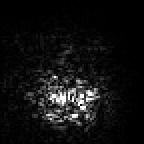

In [60]:
#normal_img,lbp_img

img_param = Param(normal_img)
J = @diff compute_saliency(model_load,img_param,lbp_img,4)
img=visualize_saliency(grad(J, img_param))